# Parkinson's Disease Detection through Typing Patterns

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier, plot_importance
import shap


In [2]:
#Loading the dataset from UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
data = pd.read_csv(url)

if 'name' in data.columns:
    data.drop('name', axis=1, inplace=True)

print("Dataset shape:", data.shape)
data.head()

Dataset shape: (195, 23)


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


## Exploratory Data Analysis

In [3]:
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non-nul

In [4]:
print("\nClass Distribution (0 = Healthy, 1 = Parkinson's):")
print(data['status'].value_counts())


Class Distribution (0 = Healthy, 1 = Parkinson's):
status
1    147
0     48
Name: count, dtype: int64


In [5]:
print("\nStatistical Summary:")
print(data.describe())


Statistical Summary:
       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count   195.000000    195.000000    195.000000      195.000000   
mean    154.228641    197.104918    116.324631        0.006220   
std      41.390065     91.491548     43.521413        0.004848   
min      88.333000    102.145000     65.476000        0.001680   
25%     117.572000    134.862500     84.291000        0.003460   
50%     148.790000    175.829000    104.315000        0.004940   
75%     182.769000    224.205500    140.018500        0.007365   
max     260.105000    592.030000    239.170000        0.033160   

       MDVP:Jitter(Abs)    MDVP:RAP    MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
count        195.000000  195.000000  195.000000  195.000000    195.000000   
mean           0.000044    0.003306    0.003446    0.009920      0.029709   
std            0.000035    0.002968    0.002759    0.008903      0.018857   
min            0.000007    0.000680    0.000920    0.002040      0.009540  

In [6]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [7]:
print("\nUnique Values Per Column:")
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")


Unique Values Per Column:
MDVP:Fo(Hz): 195 unique values
MDVP:Fhi(Hz): 195 unique values
MDVP:Flo(Hz): 195 unique values
MDVP:Jitter(%): 173 unique values
MDVP:Jitter(Abs): 19 unique values
MDVP:RAP: 155 unique values
MDVP:PPQ: 165 unique values
Jitter:DDP: 180 unique values
MDVP:Shimmer: 188 unique values
MDVP:Shimmer(dB): 149 unique values
Shimmer:APQ3: 184 unique values
Shimmer:APQ5: 189 unique values
MDVP:APQ: 189 unique values
Shimmer:DDA: 189 unique values
NHR: 185 unique values
HNR: 195 unique values
status: 2 unique values
RPDE: 195 unique values
DFA: 195 unique values
spread1: 195 unique values
spread2: 194 unique values
D2: 195 unique values
PPE: 195 unique values


## Data Visualizations

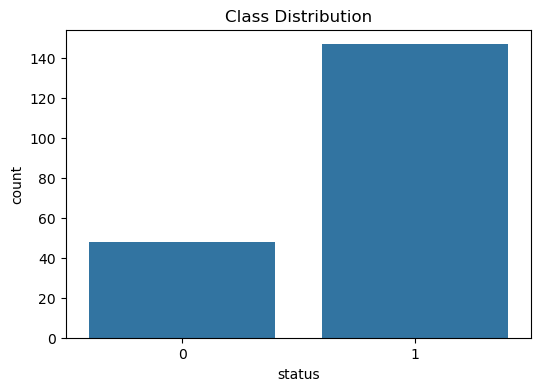

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='status', data=data)
plt.title("Class Distribution")
plt.show()

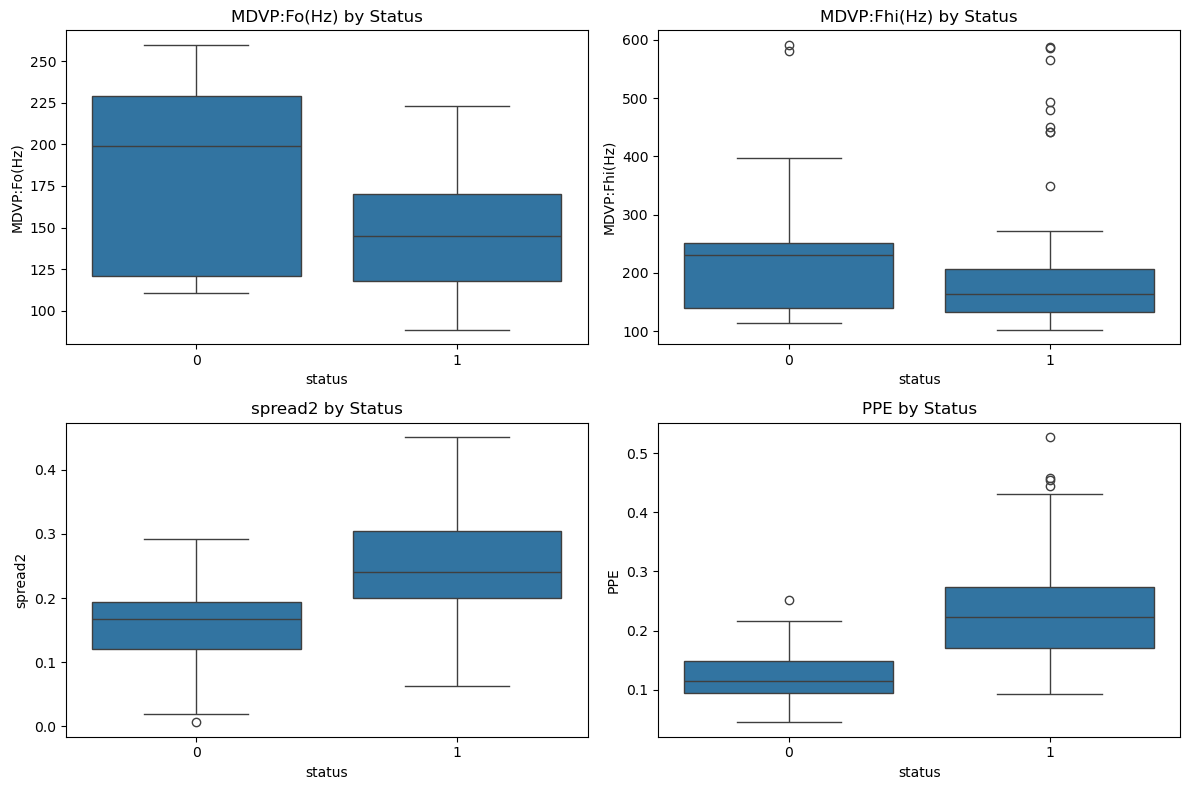

In [9]:
features_to_plot = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'spread2', 'PPE']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='status', y=feature, data=data)
    plt.title(f"{feature} by Status")
plt.tight_layout()
plt.show()

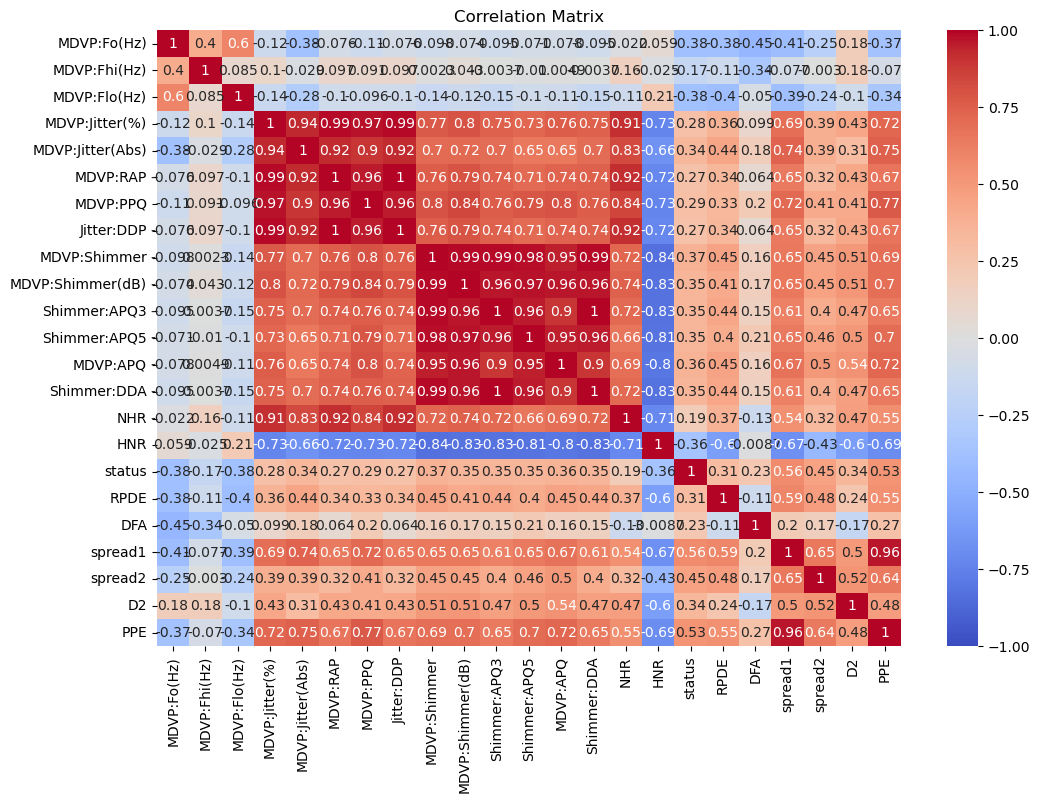

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.title("Correlation Matrix")
plt.show()

## Data Preprocessing

In [11]:
X = data.drop('status', axis=1)
y = data['status']

print("Target class distribution:")
print(y.value_counts())

Target class distribution:
status
1    147
0     48
Name: count, dtype: int64


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (156, 22)
Test shape: (39, 22)


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training(XGBoost)

In [14]:
xgb_baseline = XGBClassifier(
    random_state=42,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
)

xgb_baseline.fit(X_train, y_train)

#Prediction
y_pred_base = xgb_baseline.predict(X_test)

#Evaluation
print("Baseline XGBoost Performance:")
print(classification_report(y_test, y_pred_base))
print("Train Accuracy:", accuracy_score(y_train, xgb_baseline.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred_base))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_base))
print("F1 Score:", f1_score(y_test, y_pred_base))

Baseline XGBoost Performance:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

Train Accuracy: 1.0
Test Accuracy: 0.9230769230769231
ROC-AUC Score: 0.9155172413793103
F1 Score: 0.9473684210526315


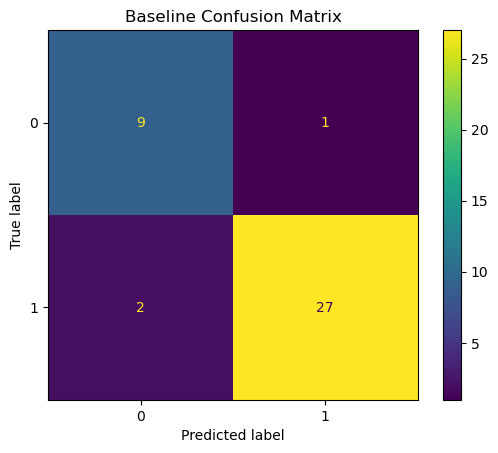

In [15]:
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Baseline Confusion Matrix")
plt.show()

## Hyperparameter Tuning

In [16]:
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

In [17]:
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
    ),
    param_distributions=param_dist,
    n_iter=20,  
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.8]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [18]:
print("Best Parameters Found:\n", random_search.best_params_)
best_model = random_search.best_estimator_

Best Parameters Found:
 {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}


## Best Model

In [19]:
xgb_final = XGBClassifier(
    **random_search.best_params_,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42
)

xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [20]:
cv_scores = cross_val_score(xgb_final, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.84375    0.90322581 0.87096774 0.80645161 0.93548387]
Mean CV Accuracy: 0.871975806451613


In [21]:
# Model Evaluation
y_pred_final = xgb_final.predict(X_test)

print("Final Model Evaluation:")
print(classification_report(y_test, y_pred_final))
print("Train Accuracy:", accuracy_score(y_train, xgb_final.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred_final))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_final))
print("F1 Score:", f1_score(y_test, y_pred_final))

Final Model Evaluation:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

Train Accuracy: 0.9935897435897436
Test Accuracy: 0.9230769230769231
ROC-AUC Score: 0.9155172413793103
F1 Score: 0.9473684210526315


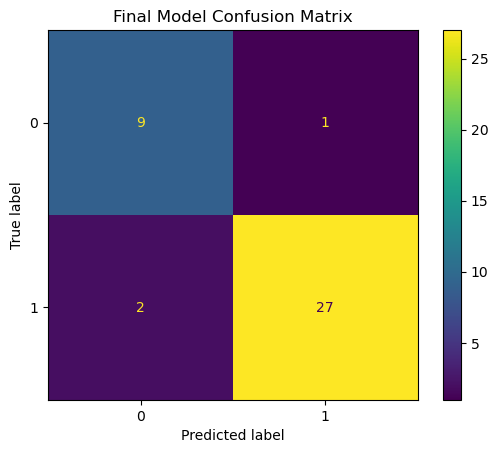

In [22]:
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Final Model Confusion Matrix")
plt.show()

<Figure size 1000x600 with 0 Axes>

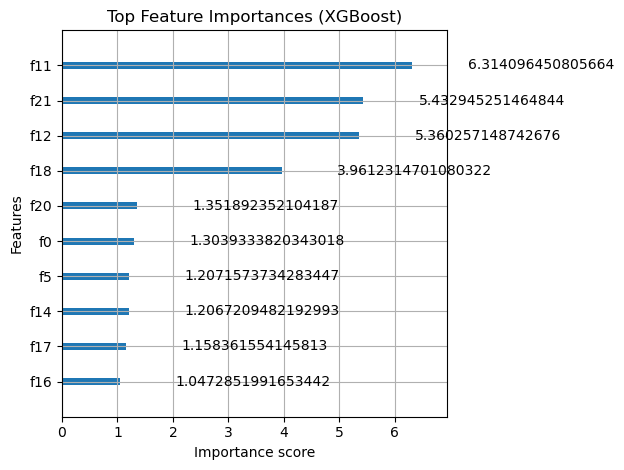

In [23]:
plt.figure(figsize=(10, 6))
plot_importance(xgb_final, max_num_features=10, importance_type='gain')
plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()